warnings: <br>
1. pillow 5.2.0 is the only version that loads the tiff files correctly! <br>
2. For nn.Identity() to work, you need pytorch > 1.0.0 (not sure by how much). However, with 1.3.1 fastai stops working well. 

In [9]:
# check for OS and set params accordingly. 
import platform
machine_OS = platform.system()
if machine_OS == 'Windows':
    batch_size = 1 
    num_workers = 0
elif machine_OS == 'Linux':
    batch_size = 2 
    num_workers = 8 
print(machine_OS, 'OS. Batchsize: ', batchsize, ' Num of workers: ', workers)

Windows OS. Batchsize:  1  Num of workers:  0


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # one of the two crushes CUDA on GCP

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # one of the two crushes CUDA on GCP

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
from tqdm import tqdm_notebook
# import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils

from torchvision import transforms

import torch.nn.functional as F

from IPython.display import display
from pathlib import Path


# Getting the data

In [4]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'

## if data needs to be downloaded

In [5]:
DataFolder.mkdir(parents=True, exist_ok=True)
DataFolder

PosixPath('/home/jupyter/RetinaProject/Data')

In [4]:
DataFolder.as_posix()

'/home/jupyter/RetinaProject/Data'

The data is on https://drive.grand-challenge.org/Download/. First you need to sign in and join. 
Then, in Chrome "More tools", go to "developer mode". Click on the link in the regular webpage. In the developer mode pane, right click on the file, and select copy cURL (bash). 

in cmd:
$ wsl \{whatever is copied\} -O -J
The -O to keep remote filenme.
The -J to preserve headers. 

PROBLEM! will save in current directory. Try 
(cd TARGET_DIRECTORY && curl ...) which will only work for linux. In windows, the wsl has problmes with the folder names and this think would not work!

In [32]:
! wsl curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J
! wsl curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J

curl: Saved to filename 'training.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  1 14.0M    1  175k    0     0   187k      0  0:01:16 --:--:--  0:01:16  187k
 93 14.0M   93 13.1M    0     0  7086k      0  0:00:02  0:00:01  0:00:01 13.4M
100 14.0M  100 14.0M    0     0  7486k      0  0:00:01  0:00:01 --:--:-- 14.0M


curl: Saved to filename 'test.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 13.8M    1  192k    0     0   212k      0  0:01:07 --:--:--  0:01:07  212k
100 13.8M  100 13.8M    0     0  7883k      0  0:00:01  0:00:01 --:--:-- 7883k


In [ ]:
## For Linux:
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)

In [43]:
## For Linux:
# if not previously installed:
# ! sudo apt-get install p7zip-full
! 7z x {DataFolder}/*.zip

ls: cannot access 'C:UsersMfastai_courseMyProject1Data/*.zip': No such file or directory


# data loading

In [5]:
# x_train_dir = DataFolder/'training_small'/'images'
# y_train_dir = DataFolder/'training_small'/'1st_manual'

x_train_dir = DataFolder/'training'/'images'
y_train_dir = DataFolder/'training'/'1st_manual'

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Custum dataloader

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
def get_mask_path(x_image_path, y_train_dir):
    """Get the path of the segmented training file for the path of an original image. \n

    Keyword arguments:
    path -- a pathlib Path to the original data image.

    Output
    SegmentedMaskPath -- a pathlib Path to the matching segmeneted training image. 
    """
    x = x_image_path
    y_ShortFilename = x.stem.replace('training', 'manual1')+ '.gif'
    y_path = y_train_dir/y_ShortFilename
    return y_path

## Making a Map-style dataset

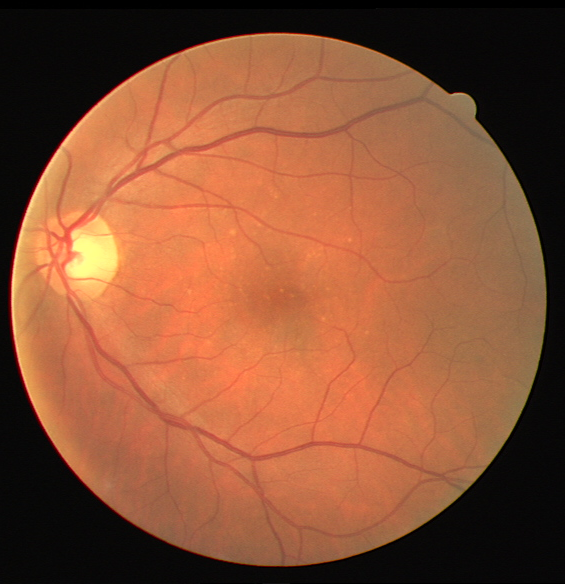

In [8]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
im = Image.open(x_images_paths[0])
display(im)

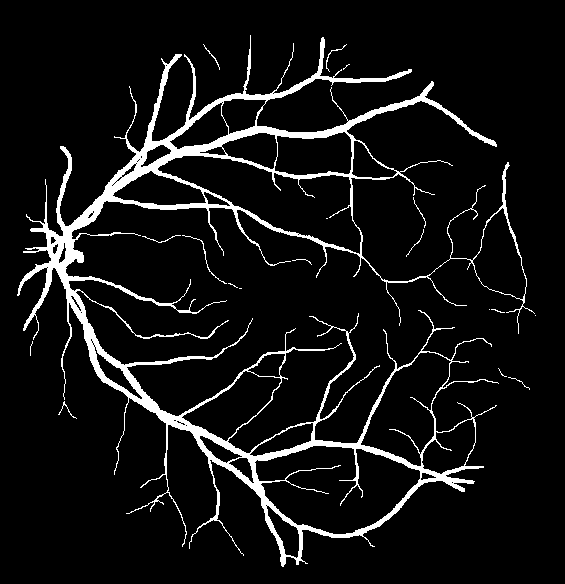

In [9]:
images_dir = x_train_dir
masks_dir = y_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
y_masks_paths = [str(get_mask_path(image_path, masks_dir).absolute()) for 
                         image_path in images_dir.glob('*.tif')]
im = Image.open(y_masks_paths[0])
display(im)
tmp_im = np.array(im)

In [8]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    Based on the CamVid Dataset example: 
    https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
    
    Args:
        images_dir (Path): path to images folder
        masks_dir (Path): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES_pool = ['no','yes']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir = None, 
            classes= None, 
            augmentation=None, 
            preprocessing=None,
            size = 640,
            interpolation = 2 # 0 means no interpolation. Mask will remain binary. 
    ):
        x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
        if not masks_dir:
            self.istest = True
        else:
            self.istest = False
        
        self.ids = [int(file_path.stem[:2]) for file_path in images_dir.glob('*.tif')]
        self.images = x_images_paths
        
        if masks_dir:
            y_masks_paths = [str(get_mask_path(image_path, masks_dir).absolute()) for 
                         image_path in images_dir.glob('*.tif')]
            self.masks = y_masks_paths
        # convert str names to class values on masks
#         self.class_values = [255,0]
        self.class_values = [self.CLASSES_pool.index(cls.lower()) for cls in classes]
        self.size = size
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.interpolation = interpolation
    
    def __getitem__(self, i):
        # read data
#         image = np.array(image)
#         mask = np.array(mask)
        
        # extract certain classes from mask (e.g. cars)
#         masks = [(mask == v) for v in self.class_values]
#         mask = np.stack(masks, axis=-1).astype('float')
        
        image = Image.open(self.images[i])
        if not self.istest:
            mask =  Image.open(self.masks[i])
        # Basic preprocessing:
        Resize = transforms.Resize(self.size, self.interpolation) # the zero is extremely important, or it will change the values
        Flip = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        CenterCrop = transforms.CenterCrop(self.size)
        ToTensor = transforms.ToTensor() # this normalizies to [0,1] range, so must appear before the ImageNet normalization
        Normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        BasicTransforms = list([
                                Resize, 
                                CenterCrop,
                                ToTensor,
                                ])
        ImageTransforms = list([
                                Resize, 
                                CenterCrop,
                                ToTensor,
                                Normalize
        ])
        ImageTransformer = transforms.Compose(ImageTransforms)
        if not self.istest:
            MaskTransformer = transforms.Compose(BasicTransforms)
#         .append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        image = ImageTransformer(image)
        if not self.istest:
            mask = MaskTransformer(mask)
        # NormTransform = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406],
        #                                                          [0.229, 0.224, 0.225])])
        # image = NormTransform(image)
        
        # apply augmentations
        if self.augmentation:
            1;
            # sample = self.augmentation(image=image, mask=mask)
            # image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            1;
            # sample = self.preprocessing(image=image, mask=mask)
            # image, mask = sample['image'], sample['mask']
        if self.istest:
            return image
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [9]:
def visualizeDataset(dataset, UnNormalize = True):
    """PLot images in one row. Only works for one class"""   
    tmp_dataset = dataset
    fig, ax, = plt.subplots(1, 2, figsize = (16,7))
    ind = np.random.randint(0,len(tmp_dataset.ids))
    
    tmp_image_tensor = (tmp_dataset[ind][0]).permute(1,2,0)
    tmp_mask_tensor = np.squeeze((tmp_dataset[ind][1]).permute(1,2,0))
    if UnNormalize:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        ax[0].imshow((tmp_image_tensor * torch.tensor(std)) + torch.tensor(mean))
    else:
        ax[0].imshow(tmp_image_tensor)
    ax[0].set(xticks=(), yticks =(), title = 'Image number ' + str(tmp_dataset.ids[ind])); 
    ax[1].imshow(tmp_mask_tensor, cmap='gray')
    ax[1].set(xticks=(), yticks =()); 

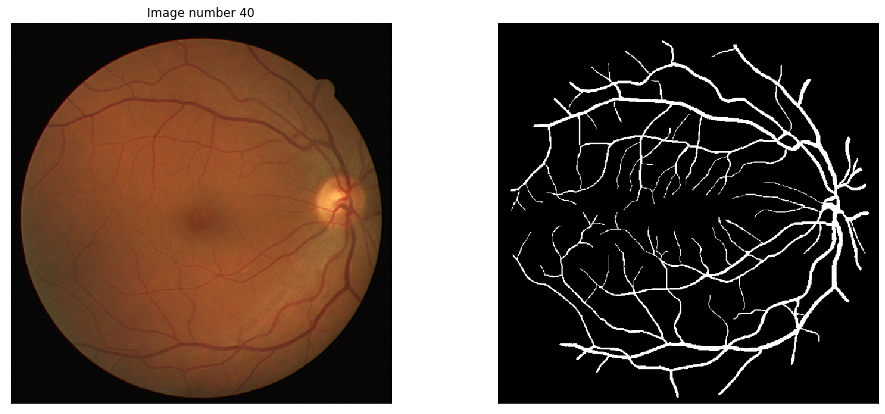

In [9]:
visualizeDataset(Dataset(x_train_dir, y_train_dir, classes=['yes']))

# Augmentation

In [9]:
# import albumentations as albu

In [ ]:
# def get_training_augmentation():
#     train_transform = [

#         albu.HorizontalFlip(p=0.5),

#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=320, width=320, always_apply=True),

#         albu.IAAAdditiveGaussianNoise(p=0.2),
#         albu.IAAPerspective(p=0.5),

#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
#                 albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
#     ]
#     return albu.Compose(train_transform)

# def to_tensor(x, **kwargs):
#     return x.transpose(2, 0, 1).astype('float32')


# def get_preprocessing(preprocessing_fn):
#     """Construct preprocessing transform
    
#     Args:
#         preprocessing_fn (callbale): data normalization function 
#             (can be specific for each pretrained neural network)
#     Return:
#         transform: albumentations.Compose
    
#     """
    
#     _transform = [
#         albu.Lambda(image=preprocessing_fn),
#         albu.Lambda(image=to_tensor, mask=to_tensor),
#     ]
#     return albu.Compose(_transform)

In [10]:
#### Visualize resulted augmented images and masks
interpolation = 2
ImageSize = 320
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(preprocessing_fn),
    classes=['yes'],
    size = ImageSize,
    interpolation = interpolation 
)

# Create model and train

In [11]:
train_loader = DataLoader(dataset = augmented_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


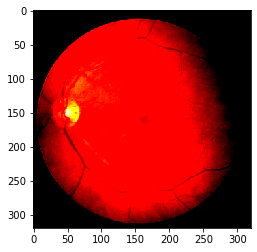

In [12]:
plt.imshow(augmented_dataset[0][0].permute(1, 2, 0))

In [13]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    """See also https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet"""
    def __init__(self, n_class , freeze = False):
        super().__init__()
        
        self.base_model = models.resnet18()
        ModelPath = Path('/home/jupyter/PretrainedModels')
        machine_OS = platform.system()
        if machine_OS == 'Windows':
            resnetPath = r"C:\Users\M\.torch\models\resnet18-5c106cde.pth"
        elif machine_OS == 'Linux': 
            resnetPath = ModelPath/ 'resnet18-5c106cde.pth'
        
        self.base_model.load_state_dict(torch.load(resnetPath))
        self.base_layers = list(self.base_model.children())
        if freeze: 
            with torch.no_grad():
                self.layer0 = nn.Sequential(*self.base_layers[:3])
        else: 
            self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        
        if freeze: 
            with torch.no_grad():
                self.layer1 = nn.Sequential(*self.base_layers[3:5])
        else: 
            self.layer1 = nn.Sequential(*self.base_layers[3:5])
        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        self.activation = nn.Sigmoid() # MHK added
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x) # -> to size 1
        # maybe add a linear with ReLU here (https://discuss.pytorch.org/t/output-of-sigmoid-last-layer-of-cnn/39757)
#         out_new = self.activation(out) # MHK added
        
        return out

In [15]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

NameError: name 'model' is not defined

In [19]:
model = torch.load((BaseFolder / 'Model320Intrpl_dice_50Epochs.pth'))

In [ ]:
model = UNet(n_class=1).cuda()

In [15]:
criterion = nn.BCEWithLogitsLoss(torch.tensor(20))
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)

In [16]:
lr = 0.1
criterion = nn.BCEWithLogitsLoss(torch.tensor(80)) # BCEWithLogitsLoss: BCE loss of sigmoid(activation)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)

In [17]:
def Sigmoid(tensor):
    return 1/(1 + torch.exp(-tensor)) 
def diceLoss(output, target):
    return 1 - 2 * (Sigmoid(output) * target).sum() / (Sigmoid(output).sum() + target.sum()) 

In [20]:
lr = 1e-5
print(lr)
for epoch in range(50):      
    model.train()         
    for ii, (data, target) in enumerate(train_loader):                         
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
#         loss = criterion(output, target) # for BCE loss.
        loss = diceLoss(output, target)

        loss.backward()
        optimizer.step()    
        if ((np.mod(epoch+1,10) == 0) and (ii == 0)):
            lr = lr/5
            print('New learning rate: ', lr)
        if loss.item() < 0.6: # this is were dice already removes the mask
            if lr > 1e-3:
                lr = 1e-3
                print('New learning rate: ', lr)
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

1e-05
Epoch: 1 - Loss: 0.482265
Epoch: 2 - Loss: 0.483126
Epoch: 3 - Loss: 0.469364
Epoch: 4 - Loss: 0.466472
Epoch: 5 - Loss: 0.468457
Epoch: 6 - Loss: 0.463530
Epoch: 7 - Loss: 0.472301
Epoch: 8 - Loss: 0.464153
Epoch: 9 - Loss: 0.473972
New learning rate:  2.0000000000000003e-06
Epoch: 10 - Loss: 0.480989
Epoch: 11 - Loss: 0.464091
Epoch: 12 - Loss: 0.475713
Epoch: 13 - Loss: 0.462677
Epoch: 14 - Loss: 0.456573
Epoch: 15 - Loss: 0.492222
Epoch: 16 - Loss: 0.485924
Epoch: 17 - Loss: 0.503453
Epoch: 18 - Loss: 0.502644
Epoch: 19 - Loss: 0.469851
New learning rate:  4.000000000000001e-07
Epoch: 20 - Loss: 0.479475
Epoch: 21 - Loss: 0.485769
Epoch: 22 - Loss: 0.470581
Epoch: 23 - Loss: 0.475000
Epoch: 24 - Loss: 0.485340
Epoch: 25 - Loss: 0.451191
Epoch: 26 - Loss: 0.456659
Epoch: 27 - Loss: 0.462563
Epoch: 28 - Loss: 0.469099
Epoch: 29 - Loss: 0.489696
New learning rate:  8.000000000000001e-08
Epoch: 30 - Loss: 0.477866
Epoch: 31 - Loss: 0.493687
Epoch: 32 - Loss: 0.492702
Epoch: 33 - 

In [35]:
torch.save(model, str(BaseFolder / 'Model320Intrpl_dice_50Epochs.pth'))

/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
'dice'

In [23]:
# torch.save(model, str(BaseFolder / 'Model320Bilinear.pth'))

In [36]:
x_test_dir = DataFolder/'test'/'images'

In [37]:
test_dataset = Dataset(
    x_train_dir, 
    classes=['yes'],
)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/anaconda3/envs/torchgpu/lib/pyt

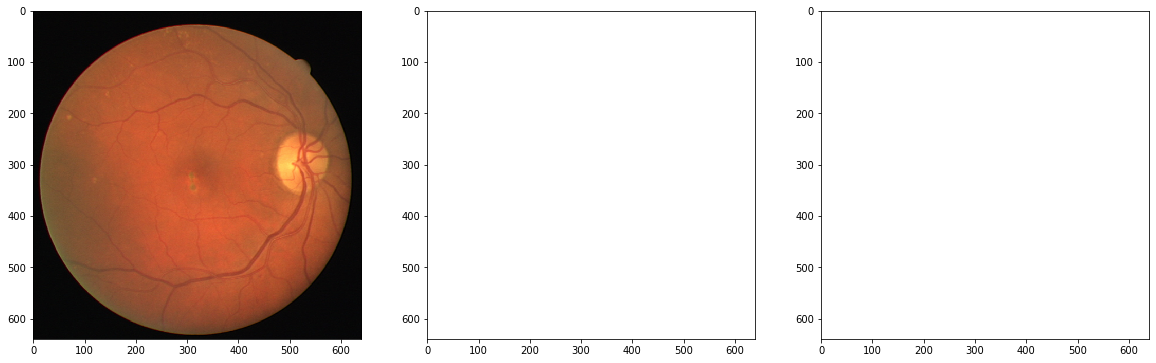

In [41]:
with torch.no_grad():
    fig, ax = plt.subplots(1,3, figsize = (20,8))

    x = test_dataset[4].unsqueeze(0)
    o = model(x.cuda())
    original_image = x.cpu().detach().numpy()
    original_image = np.transpose(original_image[0], axes = [1,2,0])
    original_image = original_image * std + mean
    output_image = o.cpu().detach().numpy() 
    output_image = np.squeeze(output_image)
    output_image = 1/(1 + np.exp(-output_image)) 
    # mn = np.mean(output_image)*5
    mn = 0.8
    output_image_thresh = np.copy(output_image)
    output_image_thresh[output_image<mn] = 0
    output_image_thresh[output_image>mn] = 1
    ax[0].imshow(original_image)
    ax[1].imshow(output_image, cmap = 'gray')
    ax[2].imshow(output_image_thresh, cmap = 'gray')

TypeError: Invalid shape (4, 320, 320) for image data

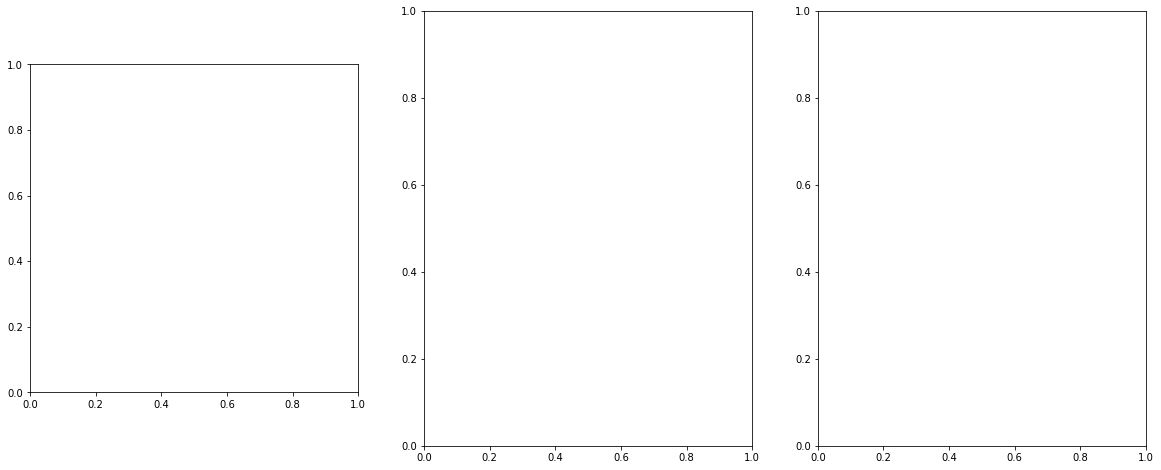

In [85]:
# if training over one bs = 1
fig, ax = plt.subplots(1,3, figsize = (20,8))
# x = augmented_dataset[0][0].unsqueeze(0)
# o = model(x.cuda())  
# tmp2 = o.cpu().detach().numpy() * (-1)
tmp2 = output.cpu().detach().numpy() 
tmp = np.copy(tmp2)
tmp3 = np.copy(tmp2)
mn = np.mean(tmp)*0.05
tmp3[tmp<mn] = 0
tmp3[tmp>mn] = 1
ax[0].imshow(np.squeeze(tmp3), cmap = 'gray')

target_numpy = target.cpu().detach().numpy()
ax[1].imshow(np.squeeze(target_numpy), cmap = 'gray')
ax[2].imshow(np.squeeze(tmp2), cmap = 'gray')